In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re, string
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import shap

In [2]:
file = "cleaned_train.csv"
df = pd.read_csv(file)

In [14]:
# Remove null values
df['processed_comment_text'] = df['processed_comment_text'].fillna("unknown")
df['cleaned_comment_text'] = df['cleaned_comment_text'].fillna("unknown")

# Encode labels
labels = ['toxic', 'severe_toxic', 'threat', 'threat', 'insult', 'identity_hate']

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

### TF-IDF + Logistic Regression

In [15]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_comment_text'])
test_tfidf = tfidf_vectorizer.transform(test_data['processed_comment_text'])

In [16]:
# Logistic Regression classifier for each class
lr_model = LogisticRegression(max_iter=1000)
metrics_lr = {}

models_lr = {}

# Use train_data to fit the model
for label in labels:
    lr_model.fit(train_tfidf, train_data[label])
    preds = lr_model.predict(test_tfidf)
    metrics_lr[label] = {
        'accuracy': accuracy_score(test_data[label], preds),
        'f1': f1_score(test_data[label], preds),
        'precision': precision_score(test_data[label], preds),
        'recall': recall_score(test_data[label], preds)
    }

    # save models for SHAP
    models_lr[label] = lr_model

print("Baseline (TF-IDF + Logistic Regression) Results:", metrics_lr)

Baseline (TF-IDF + Logistic Regression) Results: {'toxic': {'accuracy': 0.9569481435061883, 'f1': 0.7306938455507644, 'precision': 0.9110459433040078, 'recall': 0.6099476439790575}, 'severe_toxic': {'accuracy': 0.9906000313332289, 'f1': 0.375, 'precision': 0.5660377358490566, 'recall': 0.2803738317757009}, 'obscene': {'accuracy': 0.9762180792730691, 'f1': 0.736, 'precision': 0.9120689655172414, 'recall': 0.6169096209912537}, 'threat': {'accuracy': 0.9976813410621964, 'f1': 0.17777777777777778, 'precision': 0.5, 'recall': 0.10810810810810811}, 'insult': {'accuracy': 0.9693247689174369, 'f1': 0.6264784433422358, 'precision': 0.8152929493545183, 'recall': 0.5086741016109045}, 'identity_hate': {'accuracy': 0.9916340278865737, 'f1': 0.26038781163434904, 'precision': 0.7014925373134329, 'recall': 0.1598639455782313}}


In [17]:
data = []

# Collect data for each label from the metrics
for label in labels:
    data.append({
        'Class': label,
        'Accuracy': metrics_lr[label]['accuracy'],
        'F1 Score': metrics_lr[label]['f1'],
        'Precision': metrics_lr[label]['precision'],
        'Recall': metrics_lr[label]['recall'],
    })

# Create the DataFrame
metrics_df_lr = pd.DataFrame(data)

# Display the DataFrame
metrics_df_lr

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.956948,0.730694,0.911046,0.609948
1,severe_toxic,0.990600,0.375000,0.566038,0.280374
2,obscene,0.976218,0.736000,0.912069,0.616910
3,threat,0.997681,0.177778,0.500000,0.108108
4,insult,0.969325,0.626478,0.815293,0.508674
5,identity_hate,0.991634,0.260388,0.701493,0.159864


In [55]:
# Extract shap values
shap_values_lr = {}
sampled_test_data = {}
sampled_test_tfidf = {}

# Sample training TF-IDF data for background distribution
bd_samples = 100
train_tfidf_bd = shap.utils.sample(train_tfidf, bd_samples, random_state=42) 

sample_size = 2000 # For sapmling test data
test_data = test_data.reset_index(drop=True) # Reed index of test data to match the indices of test TF-IDF data
seed = 43

for label in labels:
    # Sample test data and TF-IDF data for explanation
    sampled_test_data[label] = test_data.sample(n=sample_size, random_state=seed)
    seed += 1
    sampled_test_tfidf[label] = test_tfidf[sampled_test_data[label].index]

    # Reset index of sampled test data to match the indices of sampled test TF-IDF data
    sampled_test_data[label] = sampled_test_data[label].reset_index(drop=True)

    # Get SHAP values for each label
    explainer = shap.LinearExplainer(models_lr[label], train_tfidf_bd)
    shap_values_lr[label] = explainer(sampled_test_tfidf[label])


# Get words from all comments
words = tfidf_vectorizer.get_feature_names_out()

LinearExplainer explainer: 2001it [00:12, 35.03it/s] 
LinearExplainer explainer: 2001it [00:13, 36.95it/s] 


Comment:Fuck FINLAY McWALTER hes a faggot and he needs to get a fucking life faggot.
Labels:
toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 1067, dtype: int64


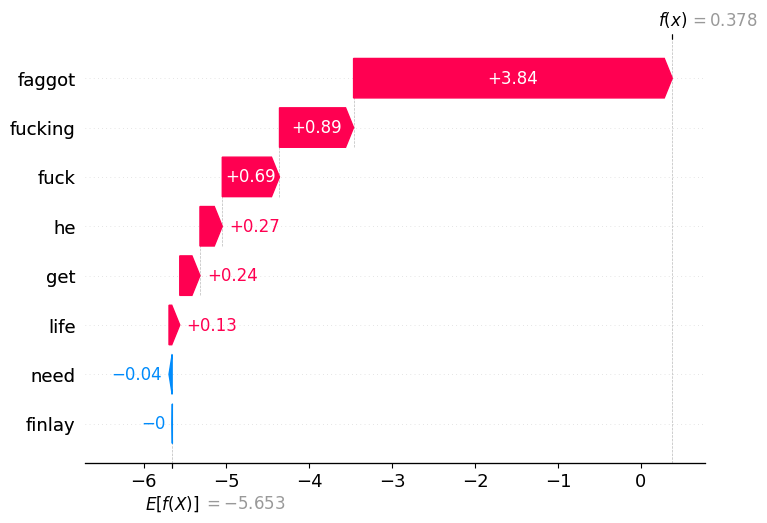

In [64]:
# Plot shap values on a waterfall plot for a toxic comment

# Get the index of a comment predicted as toxic
toxic_idx = models_lr['toxic'].predict(sampled_test_tfidf['toxic']).nonzero()[0][1]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['toxic'][toxic_idx].nonzero()[1]

print(f"Comment:{sampled_test_data['toxic']['comment_text'].iloc[toxic_idx]}")
print("Labels:")
print(sampled_test_data['toxic'][labels].iloc[toxic_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['toxic'].values[toxic_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment:"

 Request for third opinion 

User:Chubbles and myself do not agree on wheter this article should exists or not. Basically the first thread on this talk page gives an idea why. Also, User talk:Tasc0#B.26C_again should be read too.
I'll try to make my point simple:
A group called Bloods & Crips does not exist. It was actually two groups (Damu Ridas and Nationwide Rip Ridaz) that released these two albums as a collaboration. Not as a single group.  It's a zero! "
Labels:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 0, dtype: int64


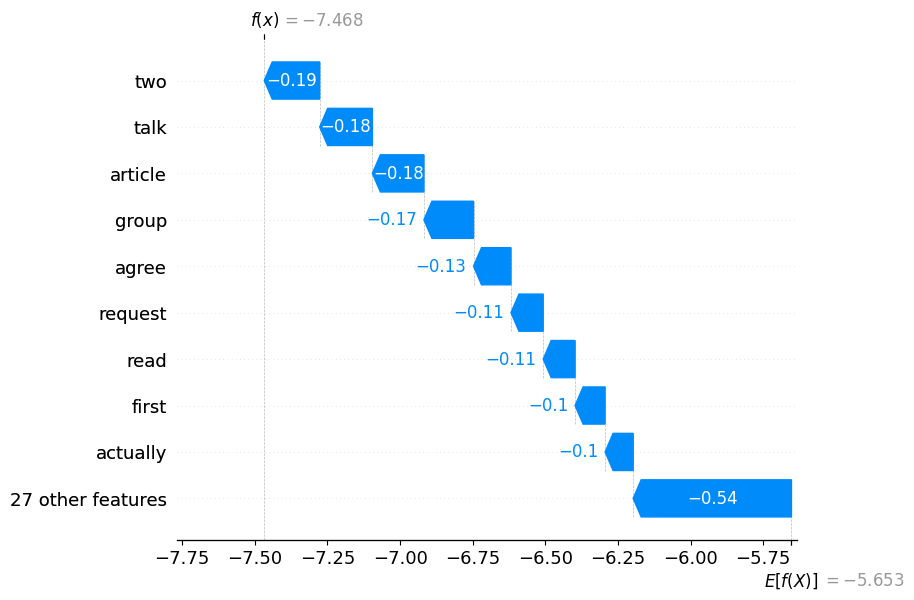

In [57]:
# Plot shap values on a waterfall plot for a non_toxic comment

# Get the index of a comment predicted as non_toxic
non_toxic_idx = np.where(models_lr['toxic'].predict(sampled_test_tfidf['toxic']) == 0)[0][0]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['toxic'][non_toxic_idx].nonzero()[1]

print(f"Comment:{sampled_test_data['toxic']['comment_text'].iloc[non_toxic_idx]}")
print("Labels:")
print(sampled_test_data['toxic'][labels].iloc[non_toxic_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['toxic'].values[non_toxic_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: ==U R GAY== 

FUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKF

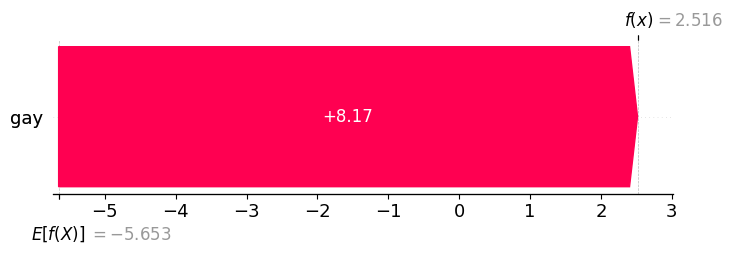

In [58]:
# Plot shap values on a waterfall plot for a severe_toxic comment

# Get the index of a comment predicted as severe_toxic
severe_toxic_idx = models_lr['severe_toxic'].predict(sampled_test_tfidf['severe_toxic']).nonzero()[0][0]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['severe_toxic'][severe_toxic_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['severe_toxic']['comment_text'].iloc[severe_toxic_idx]}")
print("Labels:")
print(sampled_test_data['severe_toxic'][labels].iloc[severe_toxic_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['severe_toxic'].values[severe_toxic_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: "

""Unsolicited"" sounds as if Sukecchi came to your son and told him he was gay. In fact, the relevant userbox sat in his userspace along with such uncontroversial personal information as his being male and what state he lives in. It's common on this site that editors declare facets of their individuality to build a sense of community that creates another incentive for us to be here and work on articles, just as workers everywhere chat around the water cooler and companies tolerate some slacking off as long as the work gets done. We have different standards on a volunteer site, but indicating someone declaring his sexual orientation will make others ""feel turned on"" is creation of unnecessary drama. - t "
Labels:
toxic            1
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64


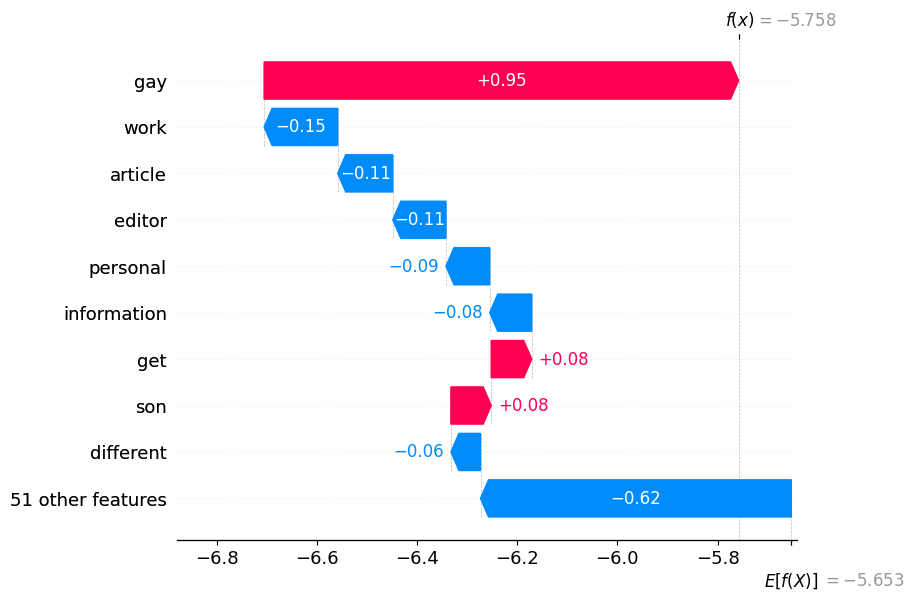

In [66]:
# Plot shap values on a waterfall plot for a non_severe_toxic comment

# Get the index of a comment predicted as non_severe_toxic
non_severe_toxic_idx = np.where(models_lr['severe_toxic'].predict(sampled_test_tfidf['severe_toxic']) == 0)[0][1]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['severe_toxic'][non_severe_toxic_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['severe_toxic']['comment_text'].iloc[non_severe_toxic_idx]}")
print("Labels:")
print(sampled_test_data['severe_toxic'][labels].iloc[non_severe_toxic_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['severe_toxic'].values[non_severe_toxic_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: FUCK YOU
you fucking faggot!
Labels:
toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 825, dtype: int64


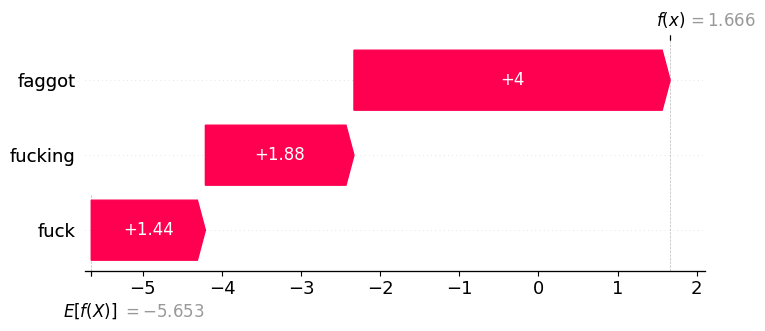

In [ ]:
# Plot shap values on a waterfall plot for an threat comment

# Get the index of a comment predicted as threat
threat_idx = models_lr['threat'].predict(sampled_test_tfidf['threat']).nonzero()[0][0]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['threat'][threat_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['threat']['comment_text'].iloc[threat_idx]}")
print("Labels:")
print(sampled_test_data['threat'][labels].iloc[threat_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['threat'].values[threat_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: REDIRECT Talk:No Games (album)
Labels:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64


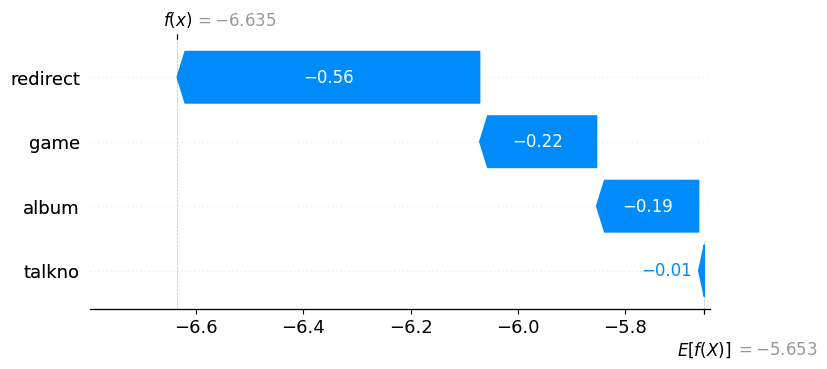

In [73]:
# Plot shap values on a waterfall plot for a non_threat comment

# Get the index of a comment predicted as non_threat
non_threat_idx = np.where(models_lr['threat'].predict(sampled_test_tfidf['threat']) == 0)[0][1]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['threat'][non_threat_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['threat']['comment_text'].iloc[non_threat_idx]}")
print("Labels:")
print(sampled_test_data['threat'][labels].iloc[non_threat_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['threat'].values[non_threat_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: My mom sucks nigger dick
Labels:
toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    1
Name: 833, dtype: int64


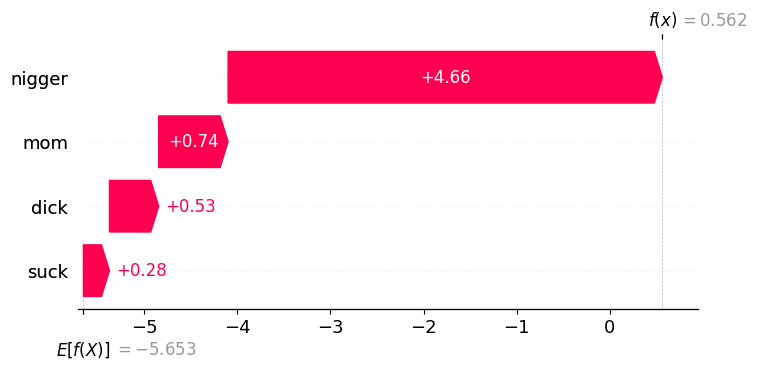

In [71]:
# Plot shap values on a waterfall plot for a threat comment

# Get the index of a comment predicted as threat
threat_idx = models_lr['threat'].predict(sampled_test_tfidf['threat']).nonzero()[0][0]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['threat'][threat_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['threat']['comment_text'].iloc[threat_idx]}")
print("Labels:")
print(sampled_test_data['threat'][labels].iloc[threat_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['threat'].values[threat_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: It's a good article, Mike. A good article with sad news. And how have you been doing lately?
Labels:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64


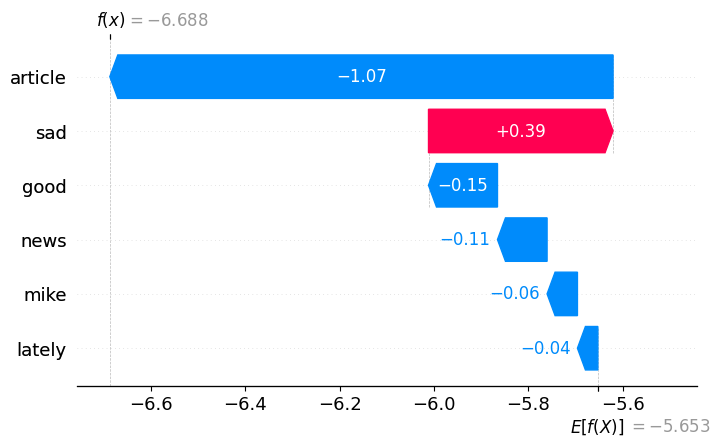

In [74]:
# Plot shap values on a waterfall plot for a non_threat comment

# Get the index of a comment predicted as non_threat
non_threat_idx = np.where(models_lr['threat'].predict(sampled_test_tfidf['threat']) == 0)[0][1]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['threat'][non_threat_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['threat']['comment_text'].iloc[non_threat_idx]}")
print("Labels:")
print(sampled_test_data['threat'][labels].iloc[non_threat_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['threat'].values[non_threat_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: You are such a nigger!
Labels:
toxic            1
severe_toxic     0
obscene          1
threat           0
insult           1
identity_hate    1
Name: 406, dtype: int64


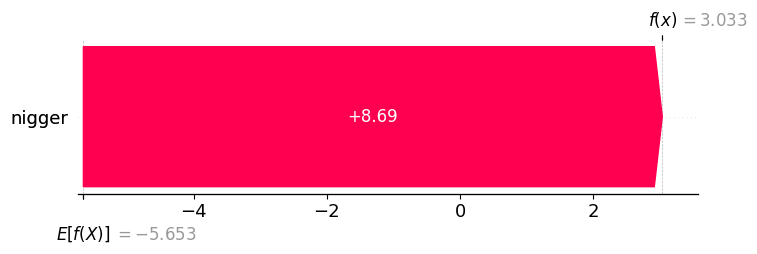

In [62]:
# Plot shap values on a waterfall plot for a insult comment

# Get the index of a comment predicted as insult
insult_idx = models_lr['insult'].predict(sampled_test_tfidf['insult']).nonzero()[0][0]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['insult'][insult_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['insult']['comment_text'].iloc[insult_idx]}")
print("Labels:")
print(sampled_test_data['insult'][labels].iloc[insult_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['insult'].values[insult_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: This is your personal opinion that does not belong in an article.
Labels:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64


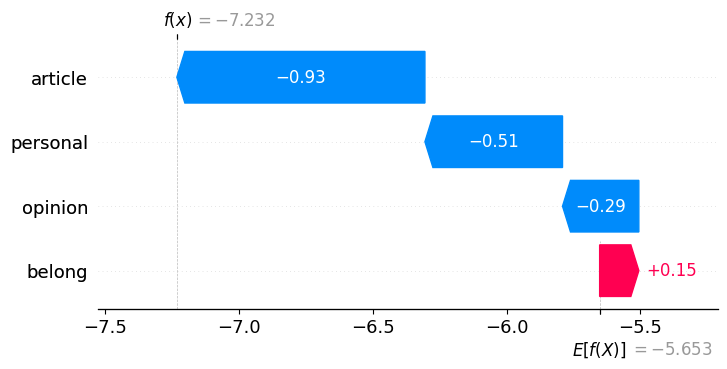

In [75]:
# Plot shap values on a waterfall plot for a non_insult comment

# Get the index of a comment predicted as non_insult
non_insult_idx = np.where(models_lr['insult'].predict(sampled_test_tfidf['insult']) == 0)[0][1]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['insult'][non_insult_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['insult']['comment_text'].iloc[non_insult_idx]}")
print("Labels:")
print(sampled_test_data['insult'][labels].iloc[non_insult_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['insult'].values[non_insult_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: hey 

your a gay nigger mother fucking cunt
Labels:
toxic            1
severe_toxic     0
obscene          1
threat           0
insult           1
identity_hate    1
Name: 778, dtype: int64


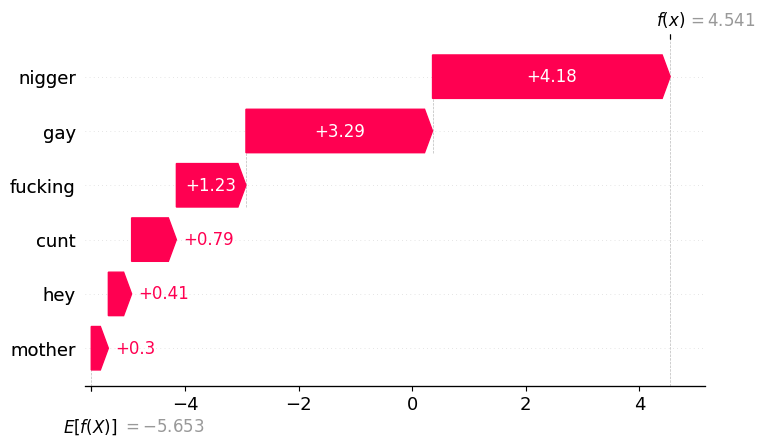

In [72]:
# Plot shap values on a waterfall plot for a identity_hate comment

# Get the index of a comment predicted as identity_hate
identity_hate_idx = models_lr['identity_hate'].predict(sampled_test_tfidf['identity_hate']).nonzero()[0][0]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['identity_hate'][identity_hate_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['identity_hate']['comment_text'].iloc[identity_hate_idx]}")
print("Labels:")
print(sampled_test_data['identity_hate'][labels].iloc[identity_hate_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['identity_hate'].values[identity_hate_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)

Comment: "

''The above discussion is preserved as an archive of the debate.  Please do not modify it. Subsequent comments should be made in a new section on this talk page. No further edits should be made to this page."
Labels:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 1, dtype: int64


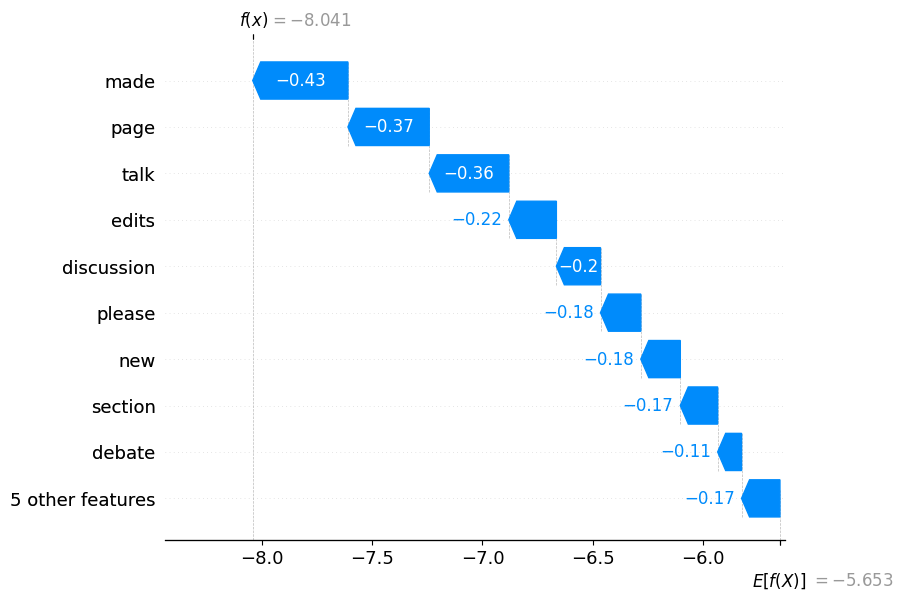

In [76]:
# Plot shap values on a waterfall plot for a non_identity_hate comment

# Get the index of a comment predicted as non_identity_hate
non_identity_hate_idx = np.where(models_lr['identity_hate'].predict(sampled_test_tfidf['identity_hate']) == 0)[0][1]

# Get the indices of words that are present in the comment
words_idx = sampled_test_tfidf['identity_hate'][non_identity_hate_idx].nonzero()[1]

print(f"Comment: {sampled_test_data['identity_hate']['comment_text'].iloc[non_identity_hate_idx]}")
print("Labels:")
print(sampled_test_data['identity_hate'][labels].iloc[non_identity_hate_idx])

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lr['identity_hate'].values[non_identity_hate_idx][words_idx],
        base_values=explainer.expected_value,
        feature_names=words[words_idx]
    )
)